In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization,Input, Flatten,  Conv1D, MaxPooling1D
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.ops import math_ops
from keras.optimizers import Adam
import keras
import tensorflow
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 
import pandas_ta as ta
import tensorflow.experimental.numpy as tnp
import scipy.stats as stats

In [199]:
# Load data
folder_path = "CSV files/"
#"S&P Global High Yield Sukuk Index" "Dow Jones Sukuk Total Return Index (ex-Reinvestment)"
names = ["Dow Jones Sukuk Total Return Index (ex-Reinvestment)", "S&P Global High Yield Sukuk Index", "S&P MENA Bond and Sukuk Index", "S&P MENA Sukuk Index" ]
name = "Dow Jones Sukuk Total Return Index (ex-Reinvestment)"
data = {}
for name in names:
    data[name] = pd.read_csv(folder_path + name + ".csv")
    print(data[name]) 
# Extract features (date) and target (price)v
X = data[name]["Effective date"]
y = data[name][name]
#pyplot.plot(data[name][name], label='Effective date')
#pyplot.show()

           Effective date  \
0     2014-02-28 00:00:00   
1     2014-03-03 00:00:00   
2     2014-03-04 00:00:00   
3     2014-03-05 00:00:00   
4     2014-03-06 00:00:00   
...                   ...   
2590  2024-02-27 00:00:00   
2591  2024-02-28 00:00:00   
2592  2024-02-29 00:00:00   
2593  2024-03-01 00:00:00   
2594  2024-03-04 00:00:00   

      Dow Jones Sukuk Total Return Index (ex-Reinvestment)  
0                                                146.75     
1                                                146.76     
2                                                146.79     
3                                                146.63     
4                                                146.49     
...                                                 ...     
2590                                             196.57     
2591                                             196.60     
2592                                             196.76     
2593                                     

In [200]:
# Adding indicators
for name in names:
    data[name]['EMAF']=ta.ema(data[name][name], length=15)
    data[name]['Price_diff'] = data[name][name].diff()
    data[name]['EMAF_diff'] = data[name]['EMAF'].diff()
    data[name]['Next_Price_diff'] = data[name][name].diff().shift(-1)
    data[name]['Next_EMAF_diff'] = data[name]['EMAF'].diff().shift(-1)
    data[name]['Next_Price'] = data[name][name].shift(-1)
    data[name].dropna(inplace=True)
    data[name].reset_index(inplace = True)
    print(data[name])

      index       Effective date  \
0        15  2014-03-21 00:00:00   
1        16  2014-03-24 00:00:00   
2        17  2014-03-25 00:00:00   
3        18  2014-03-26 00:00:00   
4        19  2014-03-27 00:00:00   
...     ...                  ...   
2574   2589  2024-02-26 00:00:00   
2575   2590  2024-02-27 00:00:00   
2576   2591  2024-02-28 00:00:00   
2577   2592  2024-02-29 00:00:00   
2578   2593  2024-03-01 00:00:00   

      Dow Jones Sukuk Total Return Index (ex-Reinvestment)        EMAF  \
0                                                146.62     146.576833   
1                                                146.66     146.587229   
2                                                146.72     146.603826   
3                                                146.84     146.633347   
4                                                146.96     146.674179   
...                                                 ...            ...   
2574                                             

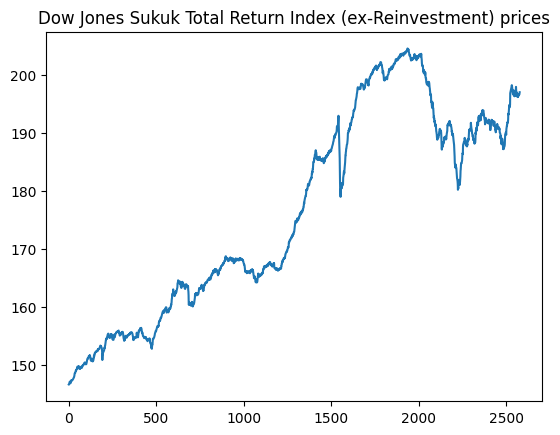

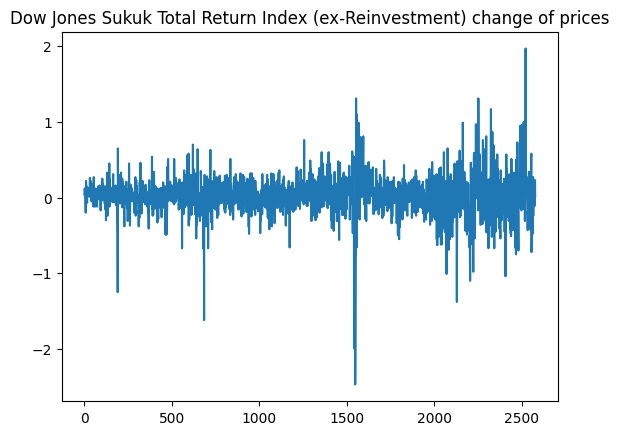

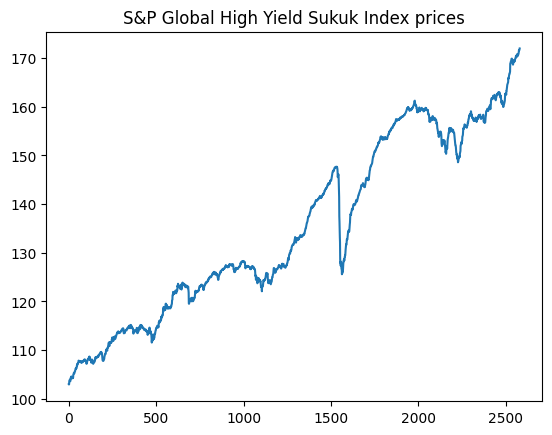

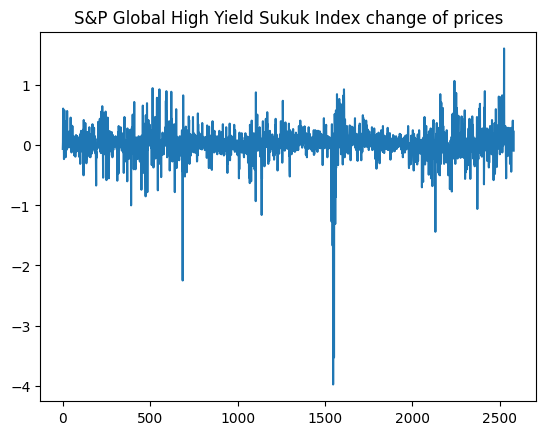

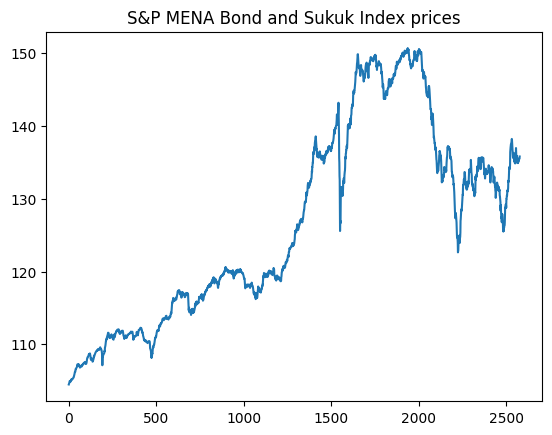

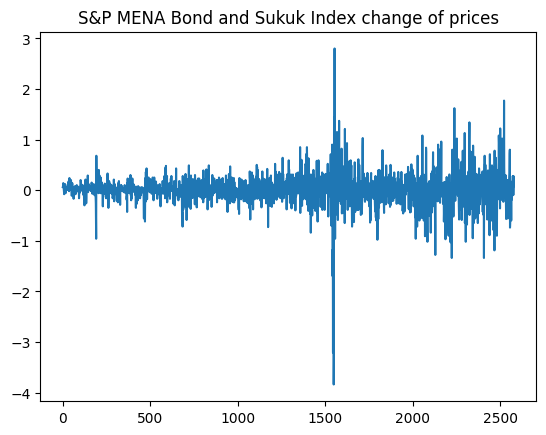

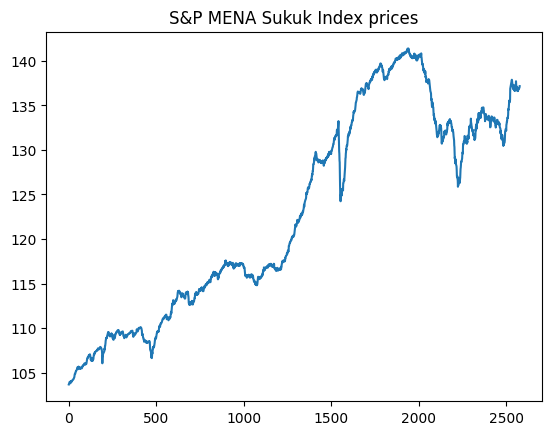

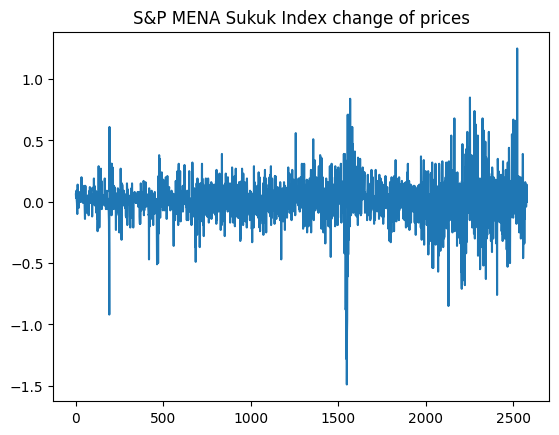

In [198]:
data_set_values = {}
for name in names:
    data_set_values[name] = data[name].iloc[:, np.r_[2,4,8]].values
    #print(data_set_values[name])
    #r_[2:4,4,5:9,11]
    data[name].iloc[:, np.r_[2,4,8]]
    #data_set_values.shape
    pyplot.title(name + " prices")
    pyplot.plot(data[name].iloc[:, 2:3], label='Effective date')
    pyplot.show()
    pyplot.title(name + " change of prices")
    pyplot.plot(data[name]["Next_Price_diff"], label='Effective date')
    pyplot.show()

In [193]:
from sklearn.preprocessing import MinMaxScaler

sc = {}
data_set_scaled = {}
for name in names:
    scc = MinMaxScaler(feature_range=(0,1))
    data_set_scaled[name] = scc.fit_transform(data_set_values[name])
    sc[name] = scc
    print( scc.data_max_)
    print(f"{name} shape:  {data_set_values[name].shape}")
#data_set_values = data_set_scaled
#print(data_set_scaled[name])

[204.53   1.97 204.53]
Dow Jones Sukuk Total Return Index (ex-Reinvestment) shape:  (2579, 3)
[172.     1.61 172.  ]
S&P Global High Yield Sukuk Index shape:  (2581, 3)
[150.62   2.8  150.62]
S&P MENA Bond and Sukuk Index shape:  (2579, 3)
[141.4    1.25 141.4 ]
S&P MENA Sukuk Index shape:  (2579, 3)


# Using 30 days in the past to predict 10 days in the future

In [192]:
X_set = {}
Y_set = {}
for name in names:
    # multiple feature from data provided to the model
    X = []
    Y = []
    #print(data_set_scaled[0].size)
    #data_set_scaled=data_set.values
    backcandles = 30
    n_forecast = 10
    print(data_set_scaled[name].shape[0])
    for j in range(data_set_scaled[name].shape[1] - 1):#data_set_scaled[0].size):#2 columns are target not X
        X.append([])
        for i in range(backcandles, data_set_scaled[name].shape[0] - n_forecast + 1):#backcandles+2
            X[j].append(data_set_scaled[name][i-backcandles:i, j])
    


    Y.append([])
    for i in range(backcandles, data_set_scaled[name].shape[0] - n_forecast + 1):
        Y[0].append(data_set_scaled[name][i: i + n_forecast, -1])


    #move axis from 0 to position 2
    X= np.moveaxis(X, [0], [2])
    Y= np.moveaxis(Y, [0], [2])
    #Erase first elements of y because of backcandles to match X length
    #del(yi[0:backcandles])
    #X, yi = np.array(X), np.array(yi)
    # Choose -1 for last column, classification else -2...
    X =np.array(X)
    Y = np.array(Y)
    #X = X.reshape(X.shape[0], backcandles)
    Y = Y.reshape(Y.shape[0], n_forecast)
    y = Y
    #yi = np.array(data_set_scaled[name][backcandles:,-1])
    #y=np.reshape(yi,(len(yi),1))
    #y=sc.fit_transform(yi)
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #print(X)
    #print(y)
    print(X.shape)
    print(y.shape)
    X_set[name] = X
    Y_set[name] = Y

2579
(2540, 30, 2)
(2540, 10)
2581
(2542, 30, 2)
(2542, 10)
2579
(2540, 30, 2)
(2540, 10)
2579
(2540, 30, 2)
(2540, 10)


# Splitting the first 80% of the dataset for training and the rest for testing

In [112]:
# Preprocess date data (consider converting to numerical format)
# This example uses string representation for simplicity
#X = pd.to_datetime(X)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
train_size = int(0.8 * len(X))
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for name in names:
    X_train[name], X_test[name] = X_set[name][:train_size], X_set[name][train_size:]
    y_train[name], y_test[name] = Y_set[name][:train_size], Y_set[name][train_size:]
    print(y_test[name].shape)
#X_test.shape
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(508, 10)
(510, 10)
(508, 10)
(508, 10)


In [79]:
X_train[name].shape[0]

2032

# Building the model

In [166]:
act = "linear"
drop = 0.01

inputLayer = Input(name= "Inputs",shape=(X_train[name].shape[1], X_train[name].shape[2]))
hidden1_flatten = Flatten( name= "Flatten")(inputLayer)

hidden2_dense = Dense(1024, activation=act, name= "hidden2_dense")(hidden1_flatten)

hidden3_dense = Dense(512, activation=act, name= "hidden3_dense")(hidden2_dense)
hidden4_dense = Dense(256, activation=act, name= "hidden4_dense")(hidden3_dense)
for i in range(2):
   hidden4_dense = Dense(128, activation=act, name= f"hidden{4+i+1}_dense")(hidden4_dense)



out_dense = Dense(Y_set[name].shape[1], activation="linear", name= "output")(hidden4_dense)



model = keras.Model(inputs = inputLayer, outputs = out_dense, name = "GeneralizedModel")

keras.utils.plot_model(model, show_shapes= True, show_layer_activations=True)
model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer= Adam(learning_rate=lr_schedule), run_eagerly=False)

Models = {}
for name in names:
   Models[name] = keras.Model(inputs = inputLayer, outputs = out_dense)
   Models[name].compile(loss='mean_squared_error', optimizer= Adam(learning_rate=lr_schedule), run_eagerly=False)
   Models[name].summary()

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)



Model: "GeneralizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 30, 2)]           0         
                                                                 
 Flatten (Flatten)           (None, 60)                0         
                                                                 
 hidden2_dense (Dense)       (None, 1024)              62464     
                                                                 
 hidden3_dense (Dense)       (None, 512)               524800    
                                                                 
 hidden4_dense (Dense)       (None, 256)               131328    
                                                                 
 hidden5_dense (Dense)       (None, 128)               32896     
                                                                 
 hidden6_dense (Dense)       (None, 128)          

# Model Architecture

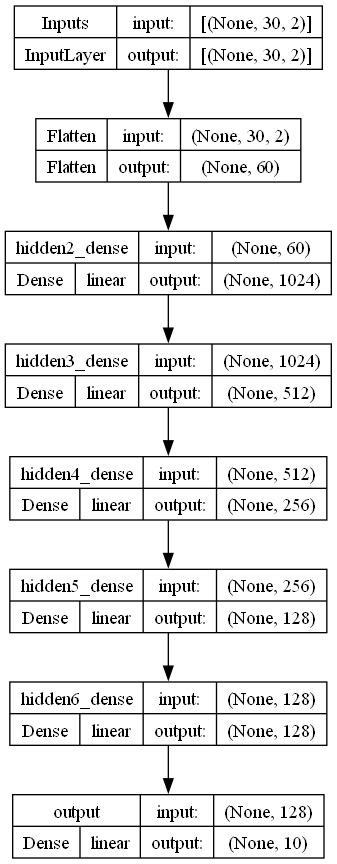

In [201]:
keras.utils.plot_model(model, show_shapes= True, show_layer_activations=True)

#### We will train one general model on all datasets, and then we will train individual specialized models on each specific index:

# Training the model "Specialized"

In [167]:
histories = {}
for name in names:
    histories[name] = Models[name].fit(X_train[name], y_train[name], validation_data=(X_test[name], y_test[name]), epochs=300, batch_size=X_set[name].shape[0], verbose=1, callbacks=[es])
    Models[name].save(f"SpecializedModels/{name}/")

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 0.4567 - val_loss: 7.2394
Epoch 2/300
1/1 [==============================] - 0s 78ms/step - loss: 4.9439 - val_loss: 0.5101
Epoch 3/300
1/1 [==============================] - 0s 81ms/step - loss: 0.3915 - val_loss: 0.7334
Epoch 4/300
1/1 [==============================] - 0s 81ms/step - loss: 0.4399 - val_loss: 0.9600
Epoch 5/300
1/1 [==============================] - 0s 76ms/step - loss: 0.5726 - val_loss: 0.7132
Epoch 6/300
1/1 [==============================] - 0s 65ms/step - loss: 0.4237 - val_loss: 0.5095
Epoch 7/300
1/1 [==============================] - 0s 66ms/step - loss: 0.3100 - val_loss: 0.3396
Epoch 8/300
1/1 [==============================] - 0s 62ms/step - loss: 0.2181 - val_loss: 0.1674
Epoch 9/300
1/1 [==============================] - 0s 64ms/step - loss: 0.1226 - val_loss: 0.0647
Epoch 10/300
1/1 [==============================] - 0s 62ms/step - loss: 0.0669 - val_loss: 0.0575
Epoch 11/300
1/1 [===

INFO:tensorflow:Assets written to: SpecializedModels/Dow Jones Sukuk Total Return Index (ex-Reinvestment)/assets


Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 4.1254e-04 - val_loss: 4.7073
Epoch 2/300
1/1 [==============================] - 0s 71ms/step - loss: 3.2475 - val_loss: 0.5890
Epoch 3/300
1/1 [==============================] - 0s 73ms/step - loss: 0.4073 - val_loss: 0.2051
Epoch 4/300
1/1 [==============================] - 0s 76ms/step - loss: 0.2090 - val_loss: 0.1296
Epoch 5/300
1/1 [==============================] - 0s 71ms/step - loss: 0.1597 - val_loss: 0.1753
Epoch 6/300
1/1 [==============================] - 0s 71ms/step - loss: 0.1522 - val_loss: 0.2326
Epoch 7/300
1/1 [==============================] - 0s 75ms/step - loss: 0.1321 - val_loss: 0.2729
Epoch 8/300
1/1 [==============================] - 0s 80ms/step - loss: 0.1231 - val_loss: 0.2016
Epoch 9/300
1/1 [==============================] - 0s 85ms/step - loss: 0.0789 - val_loss: 0.2162
Epoch 10/300
1/1 [==============================] - 0s 72ms/step - loss: 0.0888 - val_loss: 0.2340
Epoch 11/300
1/1 

INFO:tensorflow:Assets written to: SpecializedModels/S&P Global High Yield Sukuk Index/assets


Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 5.3831e-04 - val_loss: 1.6344
Epoch 2/300
1/1 [==============================] - 0s 80ms/step - loss: 1.2295 - val_loss: 0.4153
Epoch 3/300
1/1 [==============================] - 0s 85ms/step - loss: 0.3109 - val_loss: 0.1304
Epoch 4/300
1/1 [==============================] - 0s 89ms/step - loss: 0.0973 - val_loss: 0.0737
Epoch 5/300
1/1 [==============================] - 0s 91ms/step - loss: 0.0549 - val_loss: 0.1794
Epoch 6/300
1/1 [==============================] - 0s 97ms/step - loss: 0.1326 - val_loss: 0.0627
Epoch 7/300
1/1 [==============================] - 0s 88ms/step - loss: 0.0479 - val_loss: 0.0450
Epoch 8/300
1/1 [==============================] - 0s 94ms/step - loss: 0.0351 - val_loss: 0.0932
Epoch 9/300
1/1 [==============================] - 0s 91ms/step - loss: 0.0700 - val_loss: 0.0801
Epoch 10/300
1/1 [==============================] - 0s 90ms/step - loss: 0.0610 - val_loss: 0.0477
Epoch 11/300
1/1 

INFO:tensorflow:Assets written to: SpecializedModels/S&P MENA Bond and Sukuk Index/assets


Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 2.4842e-04 - val_loss: 0.8941
Epoch 2/300
1/1 [==============================] - 0s 71ms/step - loss: 0.6174 - val_loss: 0.1029
Epoch 3/300
1/1 [==============================] - 0s 70ms/step - loss: 0.0690 - val_loss: 0.0517
Epoch 4/300
1/1 [==============================] - 0s 73ms/step - loss: 0.0343 - val_loss: 0.1164
Epoch 5/300
1/1 [==============================] - 0s 72ms/step - loss: 0.0648 - val_loss: 0.0201
Epoch 6/300
1/1 [==============================] - 0s 77ms/step - loss: 0.0142 - val_loss: 0.0545
Epoch 7/300
1/1 [==============================] - 0s 72ms/step - loss: 0.0273 - val_loss: 0.0819
Epoch 8/300
1/1 [==============================] - 0s 76ms/step - loss: 0.0495 - val_loss: 0.0456
Epoch 9/300
1/1 [==============================] - 0s 76ms/step - loss: 0.0274 - val_loss: 0.0270
Epoch 10/300
1/1 [==============================] - 0s 75ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 11/300
1/1 

INFO:tensorflow:Assets written to: SpecializedModels/S&P MENA Sukuk Index/assets


# Loss history with SpecializedModels

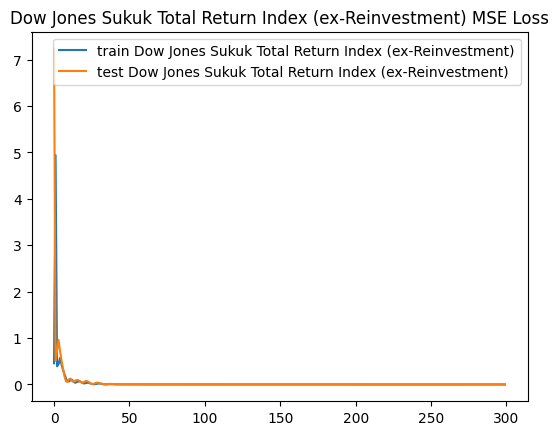

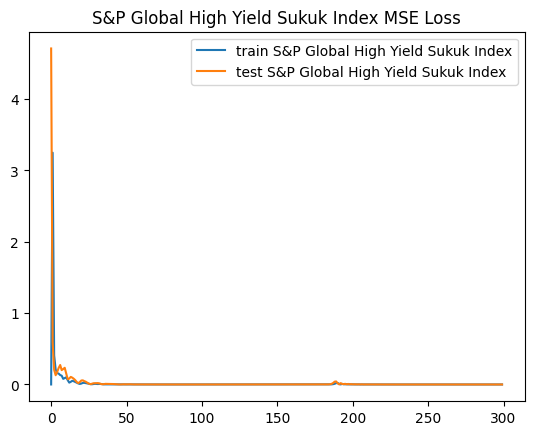

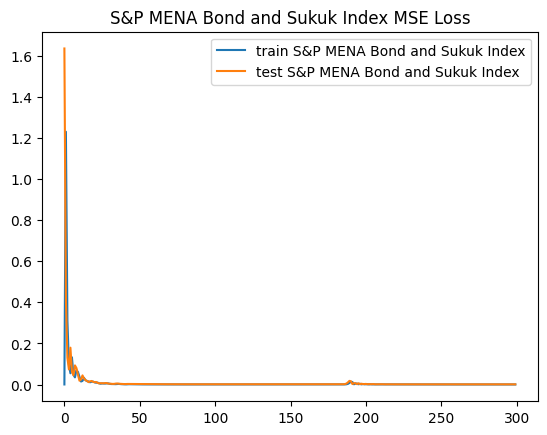

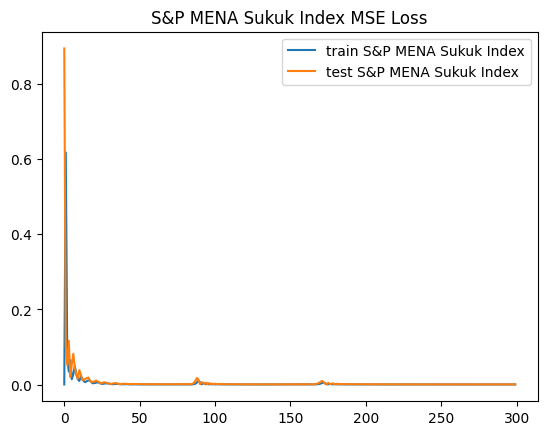

In [202]:
# Plot training history
for name in names:
    pyplot.title(name + " MSE Loss")
    pyplot.plot(histories[name].history['loss'], label=f'train {name}')
    pyplot.plot(histories[name].history['val_loss'], label=f'test {name}')
    pyplot.legend()
    pyplot.show()

# Training the model "General"

In [169]:
# Fit the model
history = {}
for i in range(3):
    for name in names:
        history[name] = model.fit(X_train[name], y_train[name], validation_data=(X_test[name], y_test[name]), epochs=50, batch_size=X_set[name].shape[0], verbose=1, callbacks=[es])

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.9018e-04 - val_loss: 1.5907
Epoch 2/50
1/1 [==============================] - 0s 68ms/step - loss: 0.9847 - val_loss: 0.0127
Epoch 3/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0098 - val_loss: 0.2734
Epoch 4/50
1/1 [==============================] - 0s 62ms/step - loss: 0.1445 - val_loss: 0.2790
Epoch 5/50
1/1 [==============================] - 0s 64ms/step - loss: 0.1499 - val_loss: 0.1173
Epoch 6/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0643 - val_loss: 0.0584
Epoch 7/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0368 - val_loss: 0.0837
Epoch 8/50
1/1 [==============================] - 0s 63ms/step - loss: 0.0495 - val_loss: 0.0393
Epoch 9/50
1/1 [==============================] - 0s 66ms/step - loss: 0.0208 - val_loss: 0.0362
Epoch 10/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0210 - val_loss: 0.0682
Epoch 11/50
1/1 [==========

In [170]:
model.save("GeneralizedModel/")
print(model.name)

INFO:tensorflow:Assets written to: GeneralizedModel/assets


INFO:tensorflow:Assets written to: GeneralizedModel/assets


GeneralizedModel


# Loss history with GeneralizedModel
### last 50 epochs of training

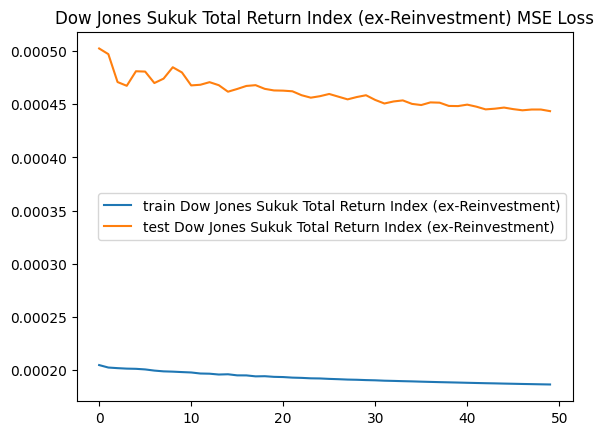

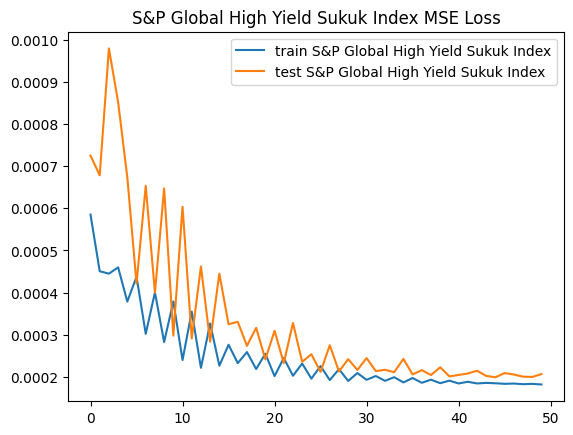

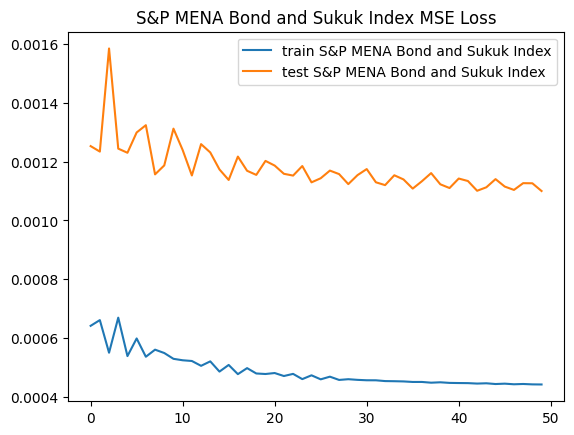

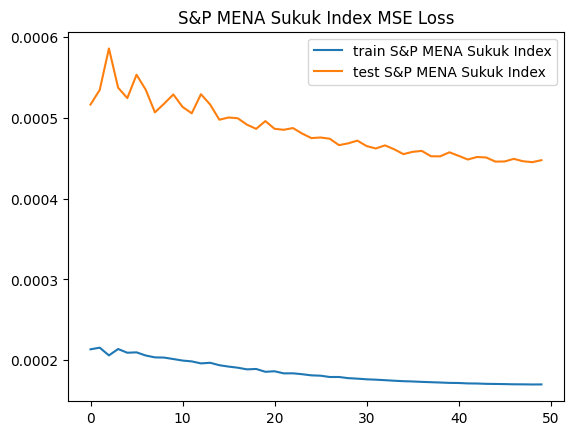

In [203]:
# Plot training history
for name in names:
    pyplot.title(name + " MSE Loss")
    pyplot.plot(history[name].history['loss'], label=f'train {name}')
    pyplot.plot(history[name].history['val_loss'], label=f'test {name}')
    pyplot.legend()
    pyplot.show()

In [190]:
#with GeneralizedModel
y_pred = {}
y_test_inversed = {}
for name in names:
    #unscaled_data = sc.inverse_transform(scaled_data)
    y_pred[name] = model.predict(X_test[name]) # * sc.data_min_[7] + (sc.data_max_[7] - sc.data_min_[7])
    y_pred[name] = np.array(y_pred[name]).reshape((-1,Y_set[name].shape[1]))
    #X = np.array(y_pred).reshape((-1,y.shape[1]))
    #y_pred = X
    #print(X.shape)
    y_test_inversed[name] =  y_test[name] * sc[name].data_min_[-1] + (sc[name].data_max_[-1] - sc[name].data_min_[-1])
    #print(np.array(y_test_inversed).shape)

    y_pred[name] = y_pred[name]  * sc[name].data_min_[-1] + (sc[name].data_max_[-1] - sc[name].data_min_[-1])
    #y_pred=np.where(y_pred > 0.43, 1,0)

    #for i in range(10):
        #print(y_pred[name][-i], y_test_inversed[name][-i])
    

    print(np.asarray(y_pred[name]).shape)
    print(np.asarray(y_test_inversed[name]).shape)

16/16 [==============================] - 0s 2ms/step
(508, 10)
(508, 10)
16/16 [==============================] - 0s 3ms/step
(510, 10)
(510, 10)
16/16 [==============================] - 0s 2ms/step
(508, 10)
(508, 10)
16/16 [==============================] - 0s 2ms/step
(508, 10)
(508, 10)


# Testing with GeneralizedModel

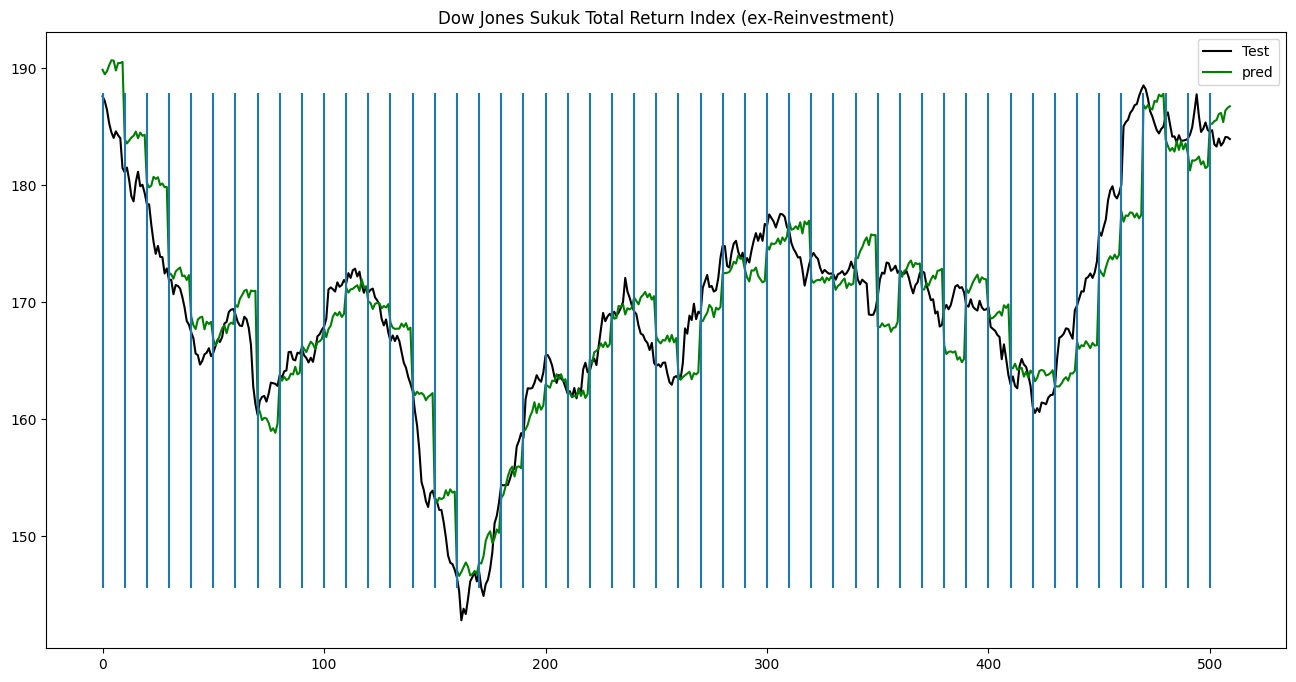

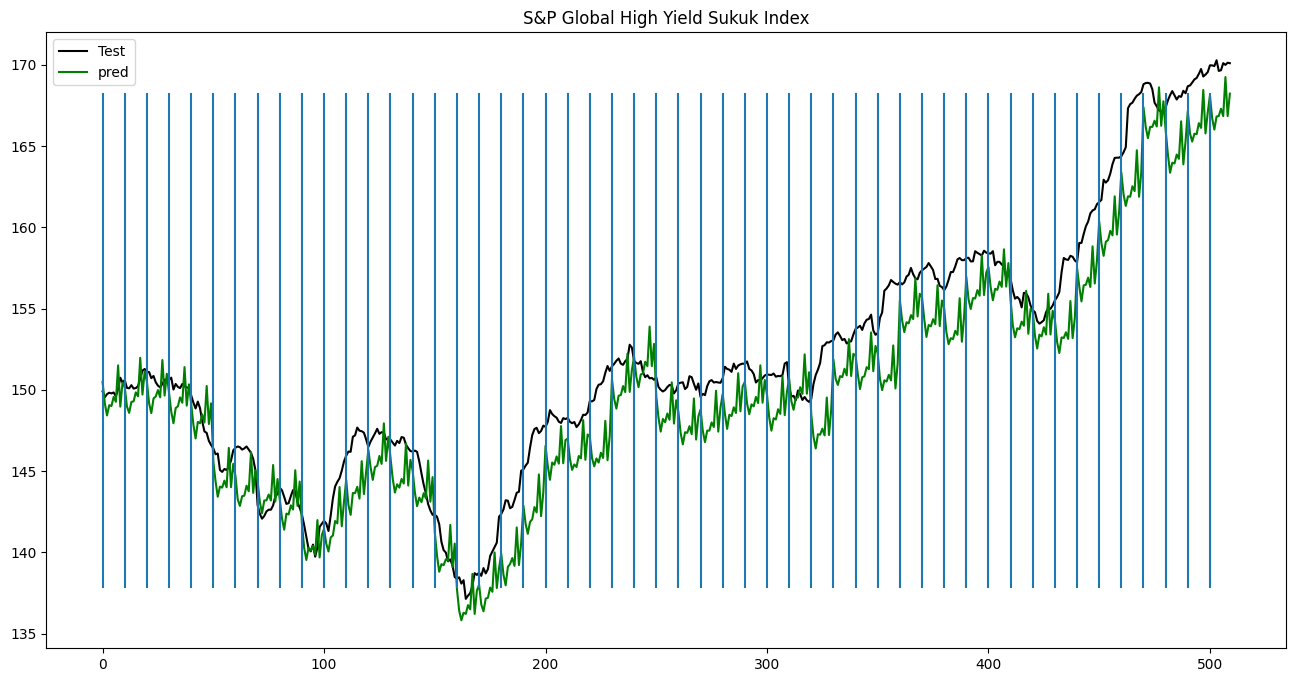

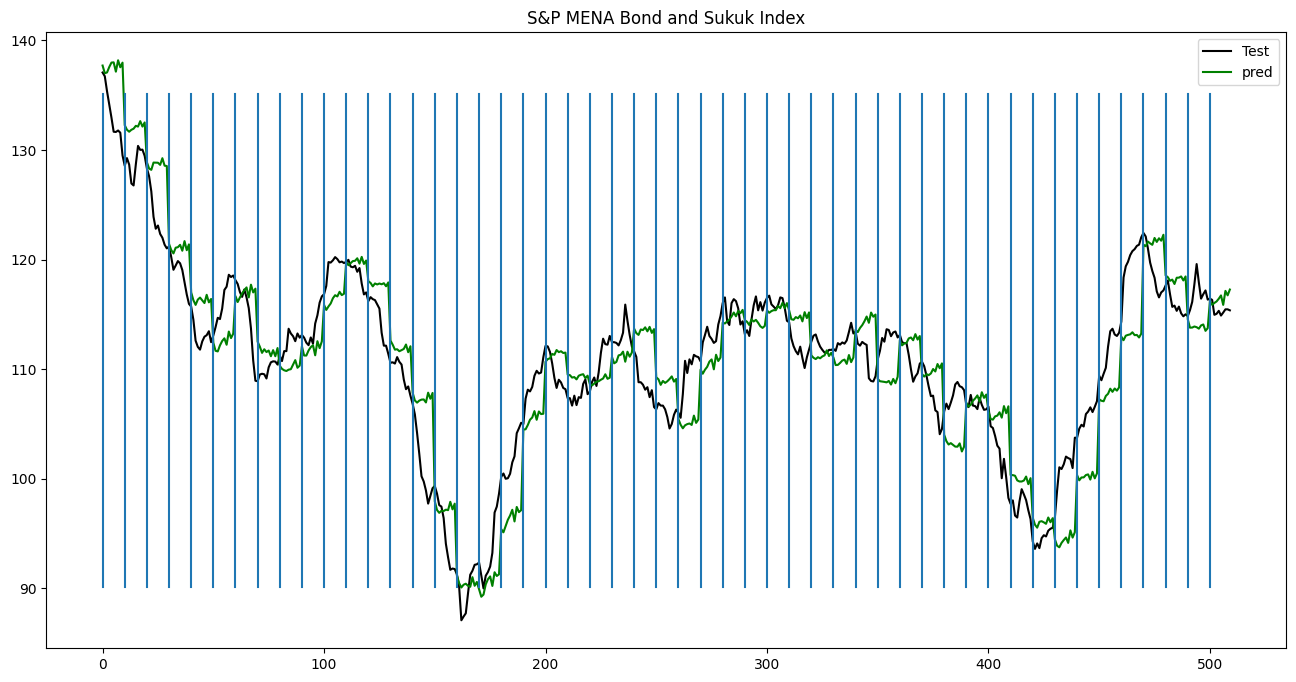

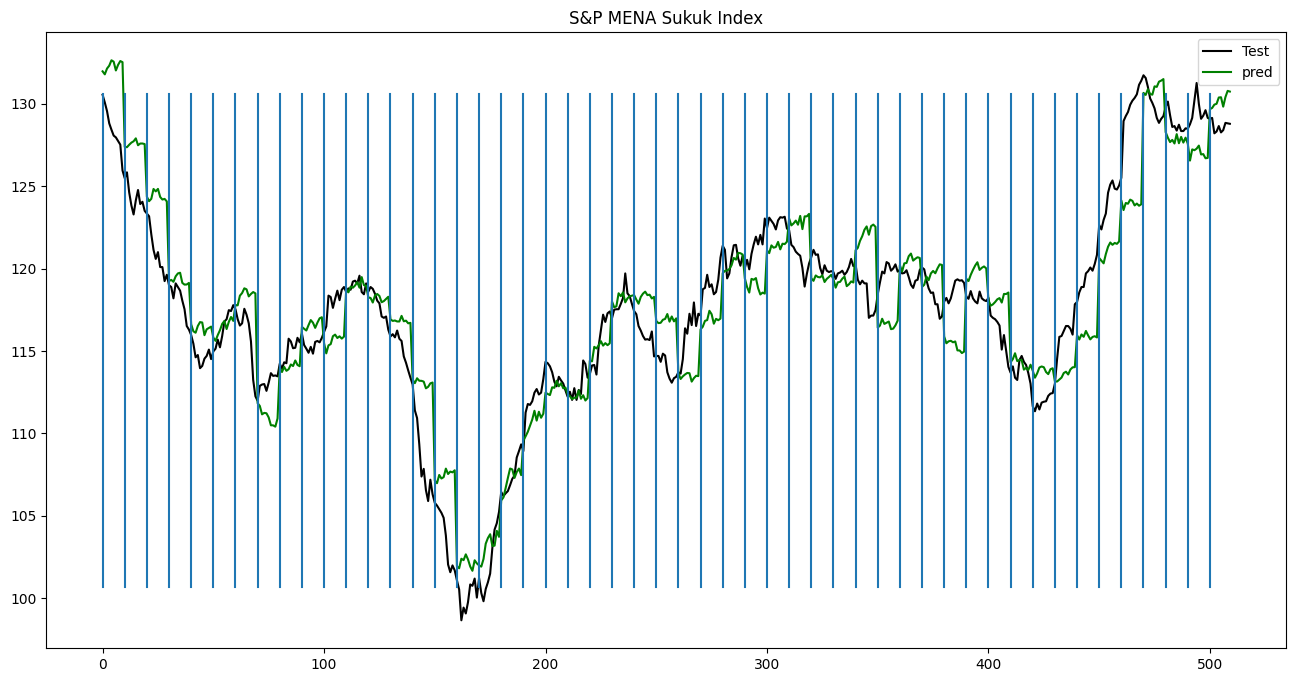

In [191]:
#with GeneralizedModel
for name in names:
    plt.figure(figsize=(16,8))
    plt.title(name)
    Y_test_inversed = []
    Y_pred = []
    splits = []
    for i in range(0,int(0.2 * len(X)),n_forecast):
        Y_test_inversed.append(y_test_inversed[name][i])
        Y_pred.append(y_pred[name][i])
        splits.append(170)
        for _ in range(n_forecast-1):
            splits.append(135)
    plt.plot( np.array(Y_test_inversed).reshape(-1), color = 'black', label = 'Test')
    plt.plot(np.array(Y_pred).reshape(-1), color = 'green', label = 'pred')
    for xc in range(0,int(0.2 * len(X)),n_forecast):
        plt.axvline(x=xc , ymax=0.9, ymin=0.1)
    plt.legend()
    plt.show()
    #print(np.array(splits).reshape(-1))
    Y_test_inversed = np.array(Y_test_inversed)
    Y_test_inversed.reshape(-1)
    Y_test_inversed.shape

In [188]:
#with SpecializedModels
y_pred = {}
y_test_inversed = {}
for name in names:
    #unscaled_data = sc.inverse_transform(scaled_data)
    y_pred[name] = keras.models.load_model(f"SpecializedModels/{name}").predict(X_test[name]) # * sc.data_min_[7] + (sc.data_max_[7] - sc.data_min_[7])
    y_pred[name] = np.array(y_pred[name]).reshape((-1,Y_set[name].shape[1]))
    #X = np.array(y_pred).reshape((-1,y.shape[1]))
    #y_pred = X
    #print(X.shape)
    y_test_inversed[name] =  y_test[name] * sc[name].data_min_[-1] + (sc[name].data_max_[-1] - sc[name].data_min_[-1])
    #print(np.array(y_test_inversed).shape)

    y_pred[name] = y_pred[name]  * sc[name].data_min_[-1] + (sc[name].data_max_[-1] - sc[name].data_min_[-1])
    #y_pred=np.where(y_pred > 0.43, 1,0)

    #for i in range(10):
        #print(y_pred[name][-i], y_test_inversed[name][-i])
    

    print(np.asarray(y_pred[name]).shape)
    print(np.asarray(y_test_inversed[name]).shape)

16/16 [==============================] - 0s 3ms/step
(508, 10)
(508, 10)
16/16 [==============================] - 0s 2ms/step
(510, 10)
(510, 10)
16/16 [==============================] - 0s 2ms/step
(508, 10)
(508, 10)
16/16 [==============================] - 0s 2ms/step
(508, 10)
(508, 10)


# Testing with SpecializedModels

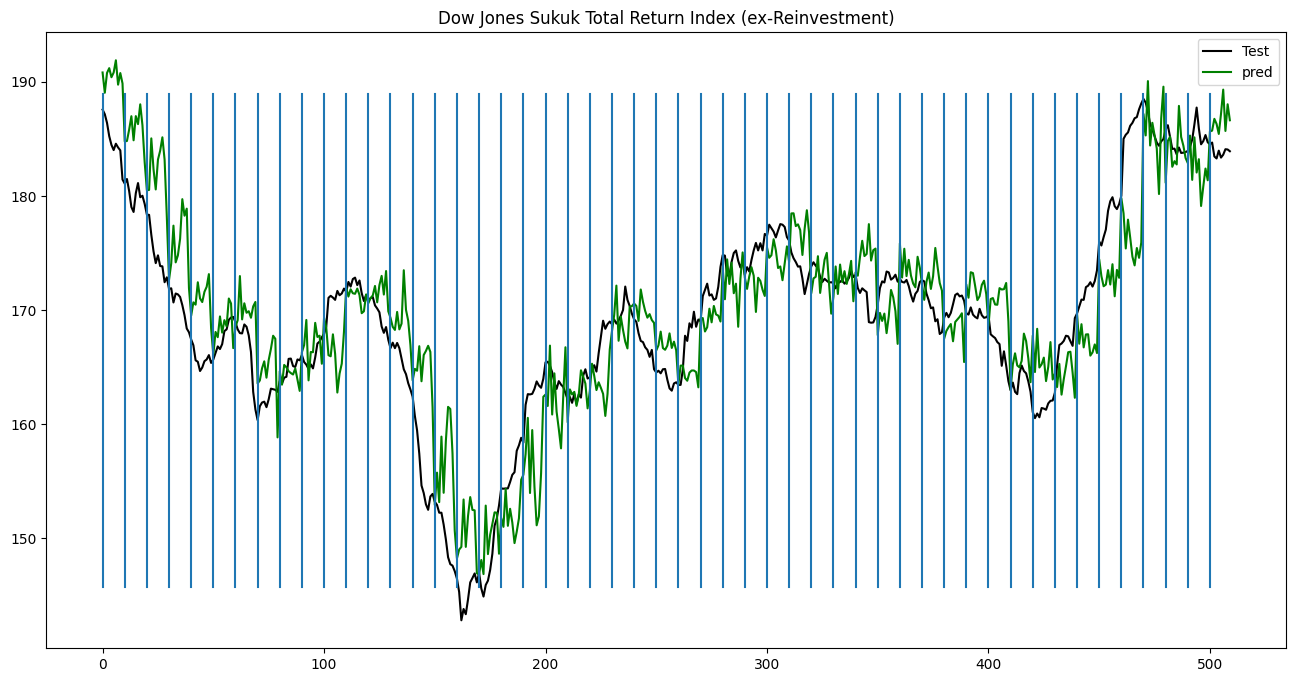

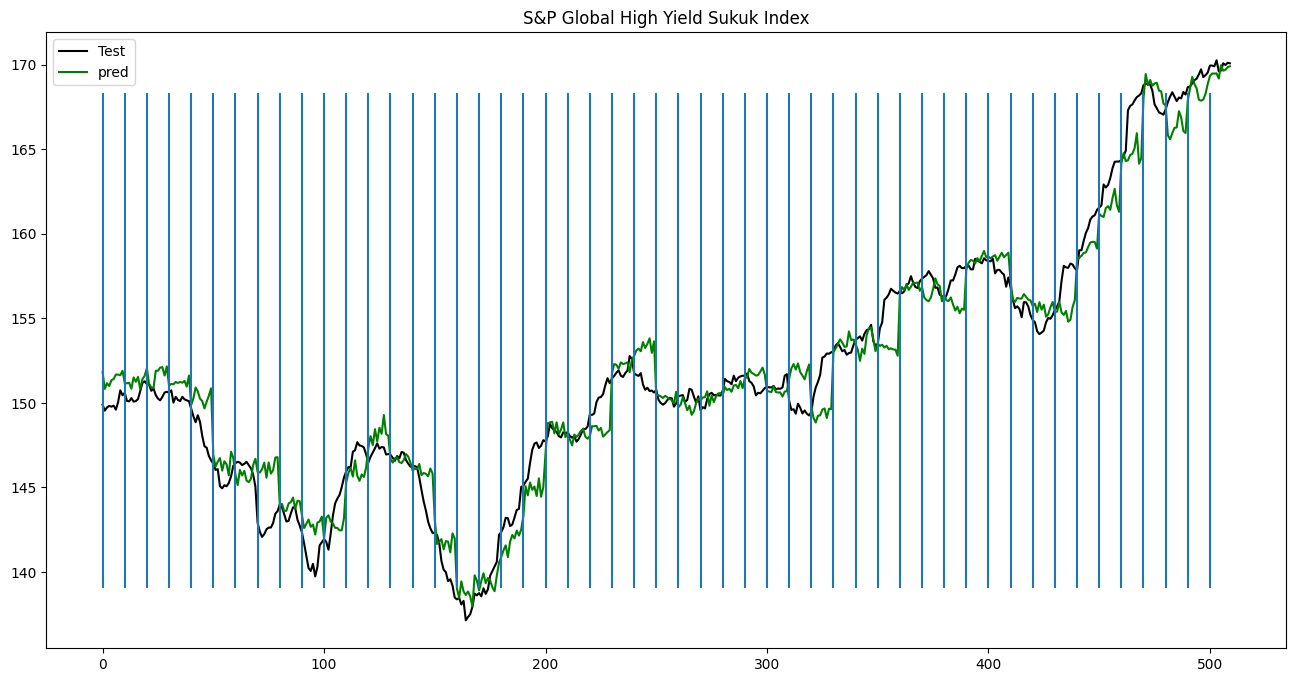

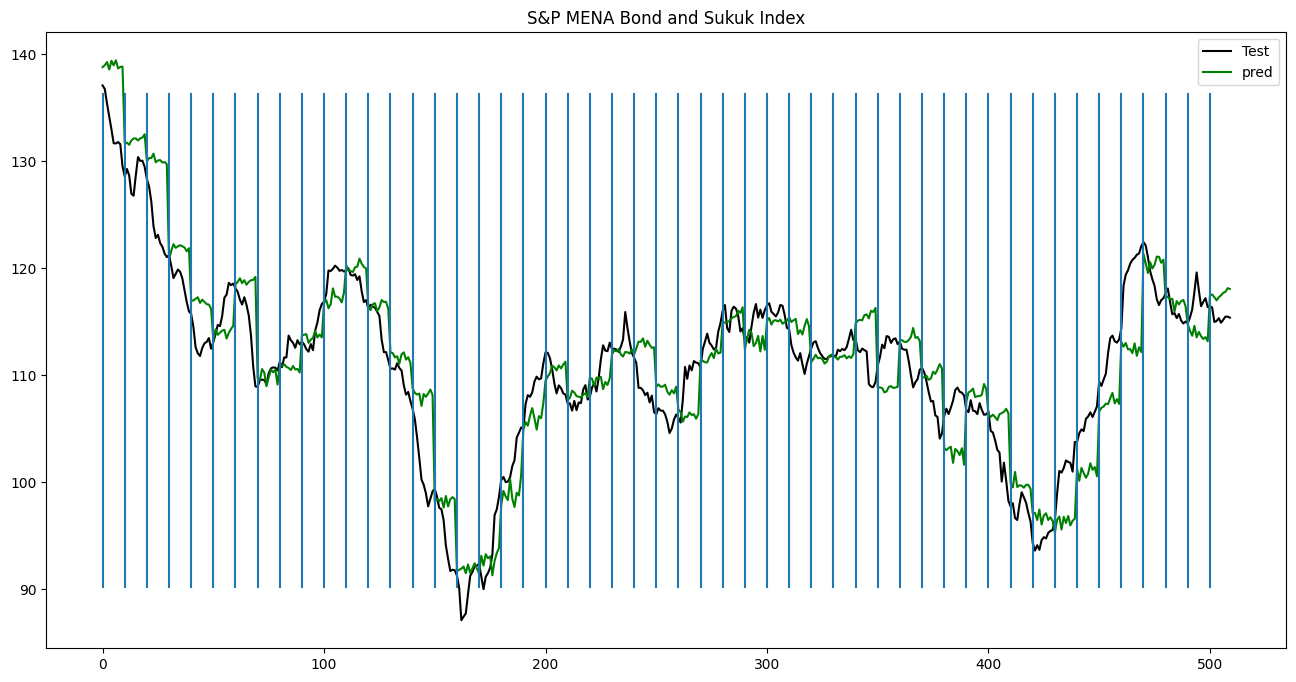

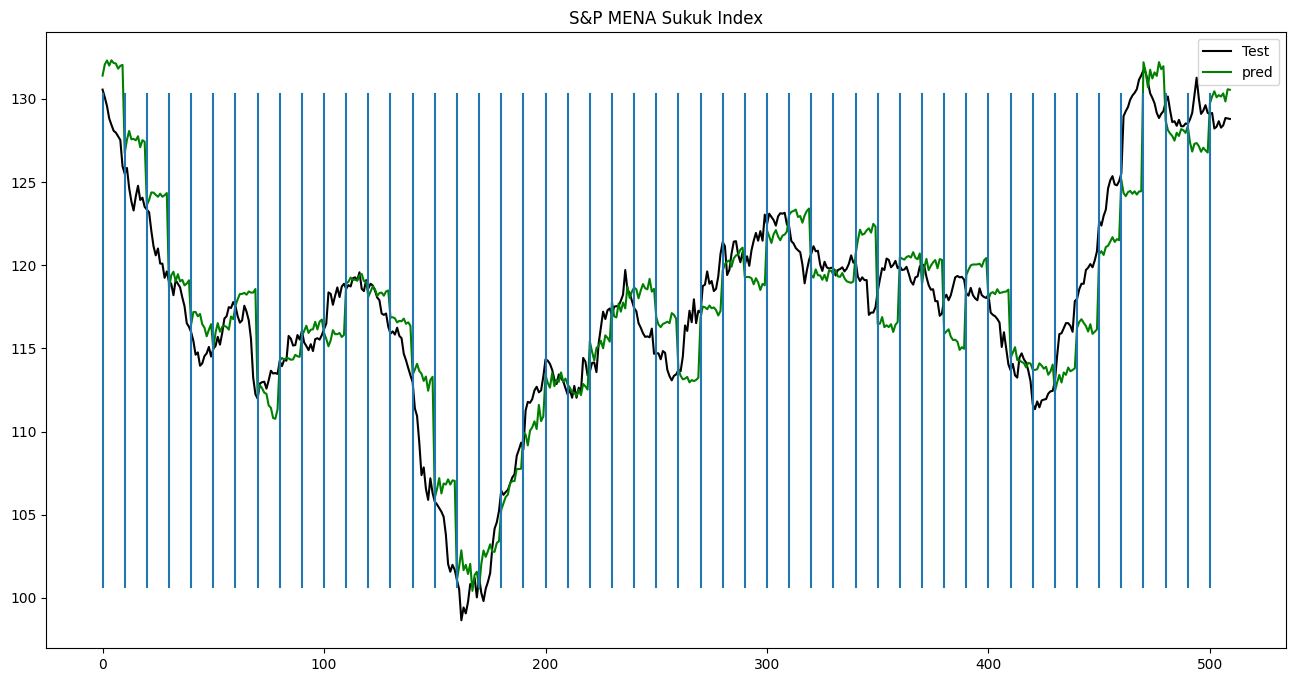

In [189]:
#with SpecializedModels
for name in names:
    plt.figure(figsize=(16,8))
    plt.title(name)
    Y_test_inversed = []
    Y_pred = []
    splits = []
    for i in range(0,int(0.2 * len(X)),n_forecast):
        Y_test_inversed.append(y_test_inversed[name][i])
        Y_pred.append(y_pred[name][i])
        splits.append(170)
        for _ in range(n_forecast-1):
            splits.append(135)
    plt.plot( np.array(Y_test_inversed).reshape(-1), color = 'black', label = 'Test')
    plt.plot(np.array(Y_pred).reshape(-1), color = 'green', label = 'pred')
    for xc in range(0,int(0.2 * len(X)),n_forecast):
        plt.axvline(x=xc , ymax=0.9, ymin=0.1)
    plt.legend()
    plt.show()
    #print(np.array(splits).reshape(-1))
    Y_test_inversed = np.array(Y_test_inversed)
    Y_test_inversed.reshape(-1)
    Y_test_inversed.shape